# Next web page prediction

This notebook is comparison of different classifiers for a problem of predicting next web page which user will visit based on the current one. Goal is to use this findings to build a WP plugin for link prefetching using the `rel="prefetch"` attribute.

`PagePaths` class is responsible for managing connection to the Google Analytics API and obtaining data from it. First argument is user's profile ID (ga:XXXXXXX), second is path to the client credentials JSON file and third start date. End date is 'today'. Check this [tutorial](https://developers.google.com/analytics/devguides/config/mgmt/v3/quickstart/installed-py) for more about GA setup. 

`get()` method returns the data directly from the API which can be written to CSV file with `write(data, file_name)`.

`paths` is a list of all web page paths (string) in the dataset. 
`connections` is a list of path indices (from, to) and number of transitions between them for certain date.

In [2]:
import configparser
import numpy as np
import pandas as pd
from page_paths import PagePaths

config = configparser.ConfigParser()
config.read('config.ini')

pp = PagePaths(config['GA']['viewID'], config['GA']['clientsecret'], '2010-01-01')

# paths, connections = pp.get()
# pp.write(paths, 'paths.csv')
# pp.write(connections, 'connections.csv')

paths = pd.read_csv('paths.csv', names=['path'], engine='c')
connections = pd.read_csv('connections.csv', names=['prev', 'next', 'count'], dtype=np.int32, engine='c')
connections.tail()

,prev,next,count
17403,3,6,1
17404,0,6,1
17405,1,477,1
17406,515,1,1
17407,6,3,1


Split connections to train and test sets (70:30).

In [5]:
from sklearn.model_selection import train_test_split
connections_train, connections_test = train_test_split(connections, test_size=0.3, shuffle=True, random_state=22)

print('paths(classes): ' + str(paths.shape))
print('train samples: ' + str(connections_train.shape))
print('test samples: ' + str(connections_test.shape))

paths(classes): (516, 1)
train samples: (12185, 3)
test samples: (5223, 3)


Before further usage, we need to split connections to feature (X) and target (y), and one-hot-encode first. X, as being quite sparse, is transformed to compressed sparse row matrix, and y to numpy array.

In [6]:
from sklearn import preprocessing
from scipy.sparse import csr_matrix

def encode(data):
    X = np.zeros(shape=(data.shape[0], paths.shape[0]))
    y = []
    counter = 0
    for index, row in data.iterrows():
        X[counter, row['prev']] = row['count']
        y.append(row['next'])
        counter += 1
    
    return csr_matrix(X), np.array(y)

X_train, y_train = encode(connections_train)
X_test, y_test = encode(connections_test)

As we are interested in n >= 1 recommendations, probabilites are predicted for each path in the dataset and then we are extracting top `PREDICTIONS_NUM` for single path. Also, accuracy is calculated for each set of predictions at step `i` and then summed up.

In [10]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

PREDICTIONS_NUM = 10

def get_predictions(classifier, X):
    probabilities = classifier.predict_proba(X)
    predictions = [p.argpartition(-PREDICTIONS_NUM)[-PREDICTIONS_NUM::][::-1] for p in probabilities]
    
    return np.array(predictions)

def get_accuracy(y_true, y_pred):
    accuracy = 0
    accuracy_cumulative = []
    
    for i in range(0, PREDICTIONS_NUM):
        accuracy += metrics.accuracy_score(y_true, y_pred[:,i])
        accuracy_cumulative.append(accuracy)
    
    return accuracy, accuracy_cumulative

def plot_accuracy(data, title):
    legend_names = []
    for row in data:
        legend_names.append(row[0])
        plt.plot(row[1:-1])
    
    plt.legend(legend_names, loc='lower right')
    plt.ylabel('accuracy')
    plt.xlabel('number of predictions')
    plt.xticks(np.arange(PREDICTIONS_NUM + 1, step=2))
    plt.show()

Here we test few classifiers and comparing them considering accuracy and execution time.

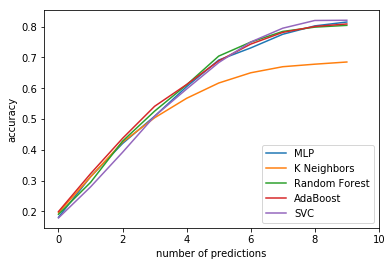

,Classifier,1,2,3,4,5,6,7,8,9,10,Duration
1,MLP,0.180548,0.312273,0.420257,0.509094,0.605208,0.691557,0.730998,0.775416,0.802604,0.815240,0:00:35.207844
2,K Neighbors,0.195290,0.311890,0.424852,0.503925,0.567298,0.616887,0.650201,0.669922,0.678154,0.685238,0:00:02.227997
3,Random Forest,0.190312,0.293892,0.427915,0.525560,0.611143,0.704384,0.749952,0.784607,0.798583,0.804327,0:00:39.264837
4,AdaBoost,0.199119,0.322037,0.437105,0.541260,0.612100,0.688685,0.743442,0.781543,0.800689,0.808922,0:01:17.278591
5,SVC,0.178442,0.279150,0.391729,0.509094,0.597549,0.683324,0.750144,0.795137,0.820218,0.820984,0:04:20.838741


In [16]:
from datetime import datetime

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=len(paths), criterion='gini', random_state=RANDOM_SEED),
    'SVC': SVC(probability=True, kernel='rbf', random_state=RANDOM_SEED),
    'AdaBoost': AdaBoostClassifier(RandomForestClassifier(), random_state=RANDOM_SEED),
    'MLP': MLPClassifier(alpha=0.0006, learning_rate_init=0.009, random_state=RANDOM_SEED),
    'K Neighbors': KNeighborsClassifier(n_neighbors=PREDICTIONS_NUM * 2, algorithm='brute')
}

result_columns = ['Classifier'] + [i for i in range(1, PREDICTIONS_NUM + 1)] + ['Duration']
result = []

for name, classifier in classifiers.items():
    start_time = datetime.now()
    classifier.fit(X_train, y_train)
    predictions = get_predictions(classifier, X_test)
    end_time = datetime.now()
    
    accuracy, accuracy_cumulative = get_accuracy(y_test, predictions)
    result.append([name] + accuracy_cumulative + [str(end_time - start_time)] )

plot_accuracy(result, name)
result = pd.DataFrame(result, columns=result_columns)
result.index += 1
display(result)

#### Conclusion
Most of the displayed models have similar accuracy and they flatten as we approach higher numbers of predictions. AdaBoost has the best start but others are close, even KNN, ~20% for one and ~42% for three predictions which is ok because we can't expect more than a few predictions in a lot of real-life scenarios. KNN also delivers fast, brute-force search does well on small and simple datasets, it could be used as a fallback model. AdaBoost with Random Forest as a weak classifier would be interesting to try to develop optimally from the scratch.

#### What's next? 
Get more data! Testing these approaches on different datasets would give us a better insight in how they would behave in the production and establish some correlations between model hyperparameters and nature of the data.